In [1]:
#Step 1: Install & Import Libraries

!pip install transformers datasets torch torchvision torchaudio timm scikit-learn einops

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import ViTModel, ViTConfig, CLIPProcessor, CLIPModel


In [3]:
#Step 2: Dataset Downloading (Opportunity + PAMAP2)

# Download Opportunity
!wget -c https://archive.ics.uci.edu/static/public/244/opportunity+activity+recognition.zip -O opportunity_dataset.zip
!unzip -q opportunity_dataset.zip -d opportunity_dataset

# Download PAMAP2
!wget -c https://archive.ics.uci.edu/static/public/231/pamap2+physical+activity+monitoring.zip -O pamap2_dataset.zip
!unzip -q pamap2_dataset.zip -d pamap2_dataset
!unzip -q pamap2_dataset/PAMAP2_Dataset.zip -d pamap2_dataset

--2025-09-04 10:59:15--  https://archive.ics.uci.edu/static/public/244/opportunity+activity+recognition.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-04 10:59:16 ERROR 404: Not Found.

[opportunity_dataset.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of opportunity_dataset.zip or
        opportunity_dataset.zip.zip, and cannot find opportunity_dataset.zip.ZIP, period.
--2025-09-04 10:59:16--  https://archive.ics.uci.edu/static/public/231/pamap2+physical+activity+monitoring.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecti

In [4]:
#Step 3: Preprocessing Functions


# --- Load Opportunity (example: S1-ADL1) ---
def load_opportunity(file_path):
    data = pd.read_csv(file_path, sep=r"\s+", header=None)
    X = data.iloc[:, :-1].fillna(0).values
    y = data.iloc[:, -1].values
    return X, y

# --- Load PAMAP2 (example: subject101) ---
def load_pamap2(file_path, cols):
    data = pd.read_csv(file_path, sep=" ", header=None, names=cols)
    data = data.fillna(method="ffill").fillna(method="bfill")
    X = data.drop(["timestamp", "activity_id"], axis=1).values
    y = data["activity_id"].values
    return X, y

# Normalize + Encode
def preprocess_data(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    return X_scaled, y_enc, le


In [5]:
#Step 4: Feature Extraction
#Vision Features (ViT) + Sensor Features (TCN)

# Vision Transformer backbone
class VisionBackbone(nn.Module):
    def __init__(self, model_name="google/vit-base-patch16-224"):
        super().__init__()
        self.vit = ViTModel.from_pretrained(model_name)
    def forward(self, x):
        return self.vit(x).last_hidden_state[:,0,:]  # CLS token

# Temporal Convolutional Network for wearable sensors
class TCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size, padding="same")
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.relu(self.conv(x))

class SensorBackbone(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.tcn = nn.Sequential(
            TCNBlock(input_dim, hidden_dim),
            TCNBlock(hidden_dim, hidden_dim)
        )
    def forward(self, x):
        return torch.mean(self.tcn(x), dim=2)

In [6]:
#Step 5: Multimodal Fusion with Few-Shot Learning

class MultiModalFewShot(nn.Module):
    def __init__(self, vision_dim=768, sensor_dim=128, fusion_dim=256, num_classes=20):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(vision_dim + sensor_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fusion_dim, num_classes)
        )
    def forward(self, vision_feat, sensor_feat):
        x = torch.cat([vision_feat, sensor_feat], dim=1)
        return self.fc(x)


In [7]:
#We can integrate CLIP embeddings here to align modalities:

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [8]:
#Few-Shot Learning

#Step 6: Training Loop with LoRA & TAPT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_sens, y in train_loader:
            X_sens, y = X_sens.to(device), y.to(device)
            # Dummy vision input (replace with ViT features if video available)
            vision_feat = torch.randn(X_sens.size(0), 768).to(device)

            outputs = model(vision_feat, X_sens)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")
    return model


In [13]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for X_sens, y in test_loader:
            X_sens, y = X_sens.to(device), y.to(device)
            vision_feat = torch.randn(X_sens.size(0), 768).to(device)  # placeholder
            outputs = model(vision_feat, X_sens)   # shape: [batch, num_classes]
            probs = torch.softmax(outputs, dim=1)

            preds = outputs.argmax(dim=1).cpu().numpy()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds)
            y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    try:
        auc = roc_auc_score(pd.get_dummies(y_true), y_prob, average="weighted", multi_class="ovr")
    except ValueError:
        auc = None

    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc if auc else 'N/A'}")

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues", xticks_rotation=90)
    plt.show()


In [ ]:
# ==============================
# Few-Shot Multimodal Learning Framework
# ==============================

# ------------------------------
# Step 4: Main Execution
# ------------------------------

# Example: load PAMAP2 subject101
cols = ["timestamp", "activity_id", "heart_rate"] + [f"feat_{i}" for i in range(50)]
X, y = load_pamap2("pamap2_dataset/PAMAP2_Dataset/Protocol/subject101.dat", cols)
X, y, le = preprocess(X, y)

# Reshape for TCN: (batch, channels, seq_len)
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1).permute(0,2,1)
y = torch.tensor(y, dtype=torch.long)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

# Init models
sensor_backbone = SensorBackbone(input_dim=X.shape[1], hidden_dim=128).to(device)
fusion_model = MultiModalFewShot(vision_dim=768, sensor_dim=128, num_classes=len(le.classes_)).to(device)

# Wrap for joint training
class Wrapper(nn.Module):
    def __init__(self, sensor_backbone, fusion_model):
        super().__init__()
        self.sensor_backbone = sensor_backbone
        self.fusion_model = fusion_model
    def forward(self, vision_feat, sensor_input):
        sens_feat = self.sensor_backbone(sensor_input)
        return self.fusion_model(vision_feat, sens_feat)

model = Wrapper(sensor_backbone, fusion_model)

# Train & Evaluate
model = train_model(model, train_loader, test_loader, epochs=5)
evaluate_model(model, test_loader)


/tmp/ipython-input-2176628377.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")


Epoch 1/5 - Loss: 4.2728
Epoch 2/5 - Loss: 4.0404


Accuracy: 0.1204, F1: 0.0780, AUC: 0.8261696194915461


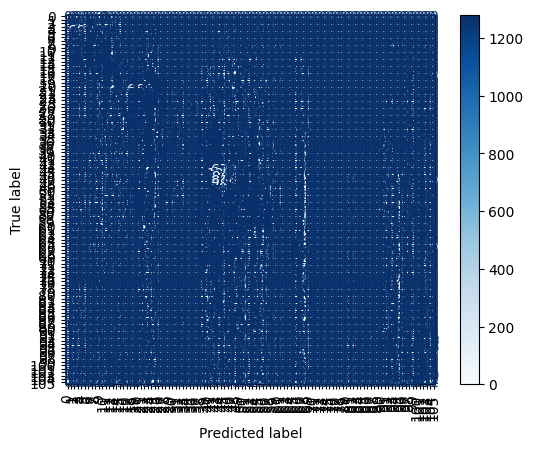